# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение общей информации. 

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [6]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Модуль 1\\Файлы\\real_estate_data.csv', sep='\t')

In [9]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

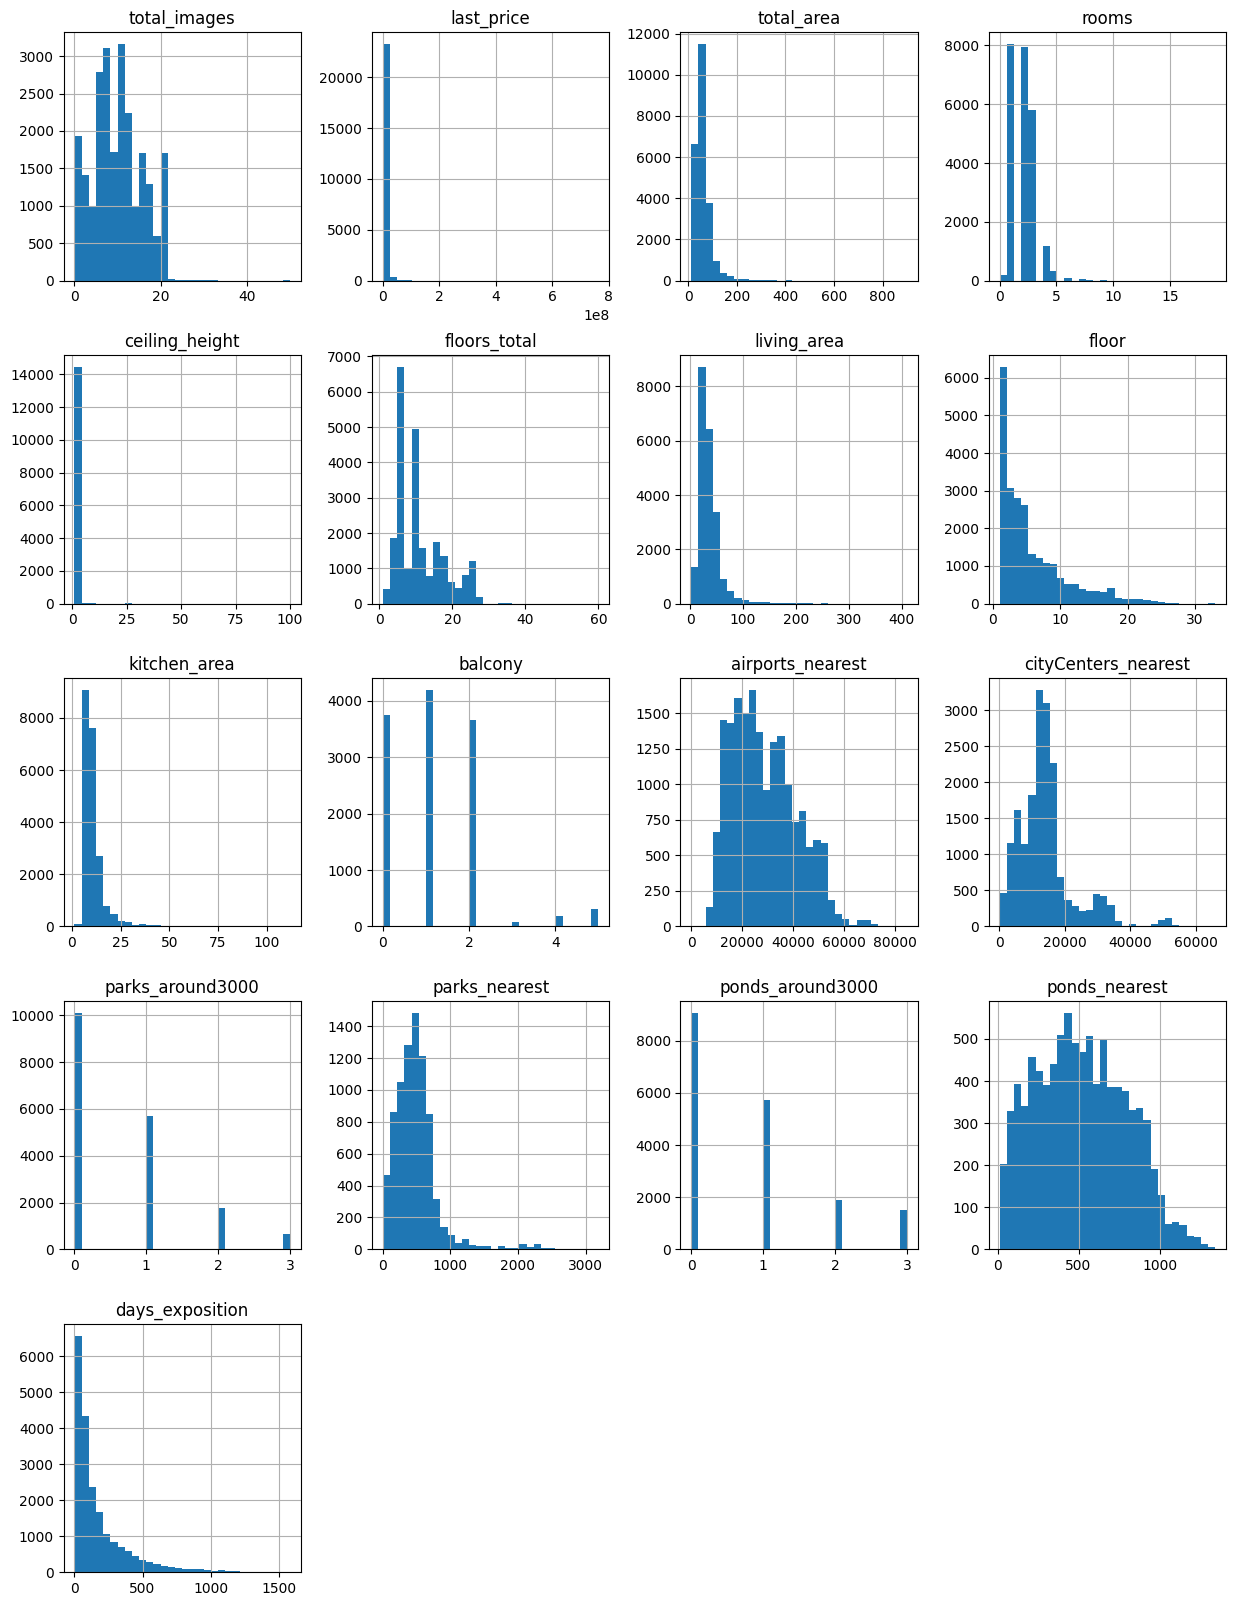

In [11]:
data.hist(bins=30,figsize=(15, 20));

**В таблице присутствуют:**   
- Данные которые не участвуют в исследовании. Пример: 'total_images'.

- Не верно указанные форматы. Пример: 'floors_total' целочисленные значения, а формат float64.

- Не корректный регистр в названиях. Пример: cityCenters_nearest

- Пропуски. Пример: 'ceiling_height'

- Редкие и выбивающиеся значения. Пример: 'ceiling_height' судя по графику, есть высоты до 100м.

## Предобработка данных

### Коррекция таблицы

В названиях изменим регистр на 'змеиный'.

In [12]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 'ponds_around3000': 'ponds_around_3000', 'parks_around3000': 'parks_around_3000'})

### Обработка пропусков

In [13]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Высоту потолка не указывают, так как считают, что везде она стандартная. Это почти верно, зависит от вида застройки. Замени медианой в зависимости от этажности здания.

In [14]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('floors_total')['ceiling_height'].transform('median'))

Данные жилой площади могут пропускать, так как более важной считают общую площадь. Замени перерасчет коэффициента отношения жилой площади к общей и количества комнат.

In [15]:
coefficient_living = data['living_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(coefficient_living * data['total_area'], inplace=True)

In [16]:
coefficient_kitchen = data['kitchen_area'].mean() / data['total_area'].mean()
data['kitchen_area'].fillna(coefficient_kitchen * data['total_area'], inplace=True)

В наименованиях и количестве этажей попусков мало, могли просто забыть вписать. Удалим.

In [17]:
data = data.dropna(subset=['floors_total']) 

In [18]:
data = data.dropna(subset=['locality_name'])

In [19]:
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)

In [20]:
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)

Пропуски могли возникнуть в связи с отссутствием данных мест. Заменим нулями.

В столбцах до ближайших объектов парк, водоем пропуски  так как их рядом нет. Оставим как есть.

В столбце days_exposition на момент анализа данных, квартира могла быть еще не продана. Оставим как есть.

В столбцах, где указано расстояние до центра города и аэропорта нет данных, так как программа могла его не найти из-за неверно указанного названия. Оставим как есть.

Пропуски могли возникнуть в связи с отсутствием балкона. Заменим на '0'.
    

In [21]:
data['balcony'] = data['balcony'].fillna(value=0)

Пропуски могли возникнуть в связи с несоответствием квартиры данной категории. Заменим на 'False'.

In [22]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)

### Обработка типов данных

В столбцах с целочисленными  значениями изменим формат на 'int'.

In [23]:
for name in ['last_price', 'floors_total', 'parks_around_3000', 'ponds_around_3000', 'balcony']:
    data[name] = data[name].astype('int')

Изменим формат времени 'datetime64'.

In [24]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Тип данных числа балконов (целочисленные) заменил на 'int' выше в цикле. Апартаменты (True, False) меняю на 'bool'.

In [25]:
data['is_apartment'] = data['is_apartment'].astype('bool')

### Обработка дубликатов

Населенным пунктам оставим только их названия, чтобы избежать разных написаний.

In [26]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [27]:
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('деревня', '')
data['locality_name'] = data['locality_name'].str.replace('посёлок городского типа', '')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', '')
data['locality_name'] = data['locality_name'].str.replace('коттеджный посёлок', '')
data['locality_name'] = data['locality_name'].str.replace('городской посёлок', '')
data['locality_name'] = data['locality_name'].str.replace('село', '')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', '')
data['locality_name'] = data['locality_name'].str.replace('посёлок при железнодорожной станции', '')
data['locality_name'] = data['locality_name'].str.replace('посёлок', '')
data['locality_name'] = data['locality_name'].str.replace('посёлок станции', '')
data['locality_name'] = data['locality_name'].str.replace('имени', '')
data['locality_name'] = data['locality_name'].str.replace(' ', '')

Проверим дубликаты во всей таблице.

### Обработка аномальных значений

Посмотрим на гистограммы сделанные в начале и выявим, где начинаются хвосты с аномально большими значениями, обрубим их.

In [28]:
data = data[(data['last_price'] < 25000000)]

In [29]:
data = data[(data['total_area'] < 200)]

In [30]:
data = data[(data['rooms'] < 6)]


При записи высоты потолка могли не там поставить запятую из-за чего появились большие значения. Уберем их.

In [31]:
for t in data['ceiling_height'].unique():
    data.loc[(data['ceiling_height'] == t) & (t > 10), 'ceiling_height'] = t / 10

Ограничим высоту. Нижнюю границу по стандарту + натяжной потолок. Верхняю домами старой застройки.

In [32]:
data = data[(data['ceiling_height'] > 2.3) & (data['ceiling_height'] < 3.50)]

In [33]:
data = data[(data['floors_total'] < 30)]

In [34]:
data = data[data['living_area'] < 100]

In [35]:
data = data[data['floor'] < 30]

In [36]:
data = data[data['kitchen_area'] < 45]

В остальных столбцах нет ярко выраженных аномалий.

In [37]:
len(data)

22117

Было удалено меньше 10% пропусков.

## Подсчет и добавление новых столбцов

Цена одного квадратного метра.

In [38]:
data['price_per_square'] = (data['last_price'] / data['total_area']).round().astype('int')

День недели публикации объявления (0 — понедельник, 1 — вторник и так далее).
Месяц публикации объявления.
Год публикации объявления.

In [39]:
data['day'] = data['first_day_exposition'].dt.weekday

In [40]:
data['month'] = data['first_day_exposition'].dt.month

In [41]:
data['year'] = data['first_day_exposition'].dt.year

In [42]:
def weekday_name(day):
    if day == 0 :
        return 'понедельник'
    if day == 1 :
        return 'вторник'
    if day == 2 :
        return 'среда'
    if day == 3 :
        return 'четверг'
    if day == 4 :
        return 'пятница'
    if day == 5 :
        return 'суббота'
    if day == 6 :
        return 'воскресенье'

In [43]:
def month_name(month):
    if month == 1:
        return 'январь'
    if month == 2:
        return 'февраль'
    if month == 3:
        return 'март'
    if month == 4:
        return 'апрель'
    if month == 5:
        return 'май'
    if month == 6:
        return 'июнь'
    if month == 7:
        return 'июль'
    if month == 8:
        return 'август'
    if month == 9:
        return 'сентябрь'
    if month == 10:
        return 'октябрь'
    if month == 11:
        return 'ноябрь'
    if month == 12:
        return 'декабрь'

In [44]:
data['day'] = data['day'].apply(weekday_name)
data['month'] = data['month'].apply(month_name)

Тип этажа квартиры (значения — «первый», «последний», «другой»).

In [45]:
def create_floor_category(row):
    floor = row['floor']
    if floor == 1:
        return 'первый'
    if floor == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [46]:
data['category_floor'] = data.apply(create_floor_category, axis=1)

Расстояние до центра города в километрах.

In [47]:
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round()

## Исследовательский анализ данных

### Изучем следующие параметры объектов:

<Axes: >

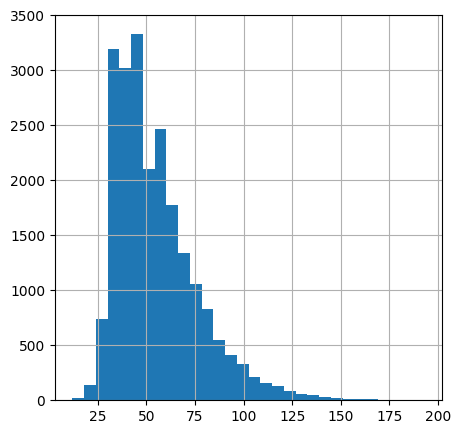

In [48]:
data['total_area'].hist(bins=30,figsize=(5, 5))

Большинство квартир имеют площадь 45кв.м.

<Axes: >

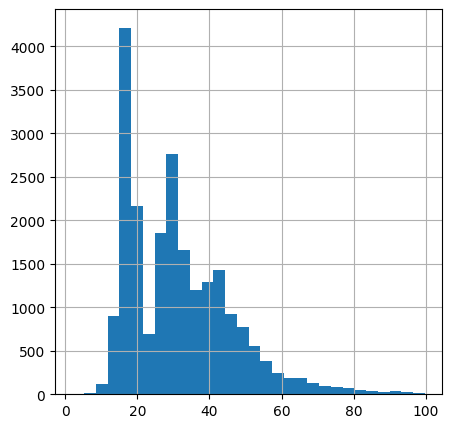

In [49]:
data['living_area'].hist(bins=30,figsize=(5, 5))

В первом пике могут находиться  квартиры студии. Второй пик предположу начинается с однокомнатных.

<Axes: >

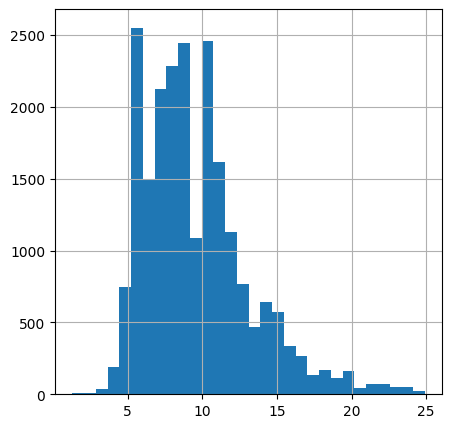

In [53]:
data['kitchen_area'].hist(bins=30,figsize=(5, 5))

Три пика на это может влиять какой-то параметр. Возможно планировка.

<Axes: >

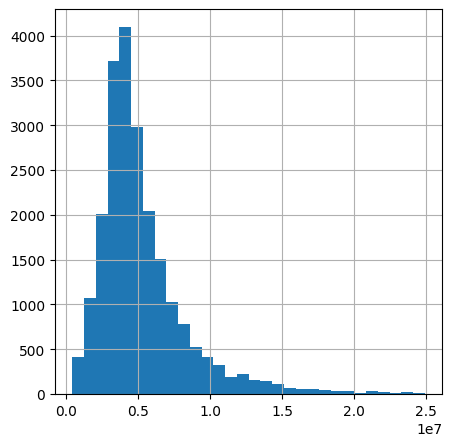

In [54]:
data['last_price'].hist(bins=30,figsize=(5, 5))

Большинство квартир стоит в районе 4.000.000р.

<Axes: >

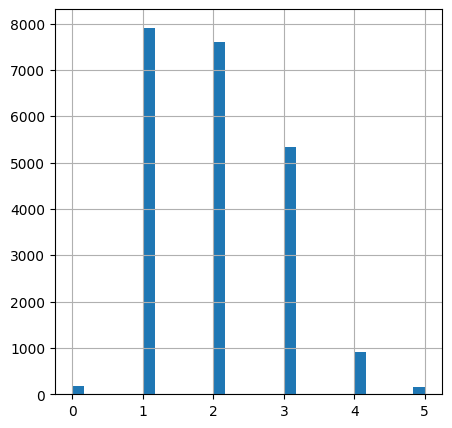

In [55]:
data['rooms'].hist(bins=30,figsize=(5, 5))

Самые распространенные квартиры имеют 1, 2 комнаты.

<Axes: >

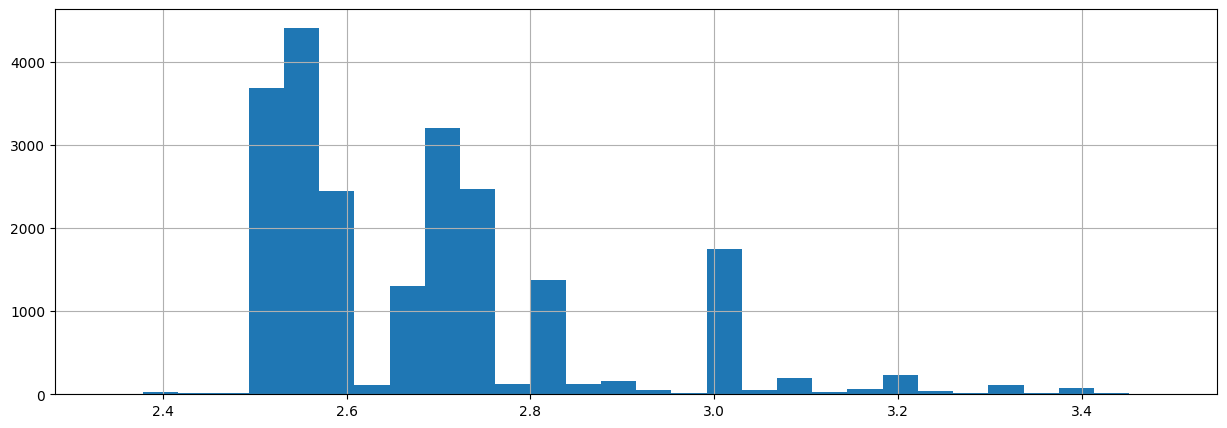

In [56]:
data['ceiling_height'].hist(bins=30,figsize=(15, 5))

Самая распространённая высота 2.5м. Второй пик может быть вызван тем, что большое количество пропусков заменили медианой.

<Axes: >

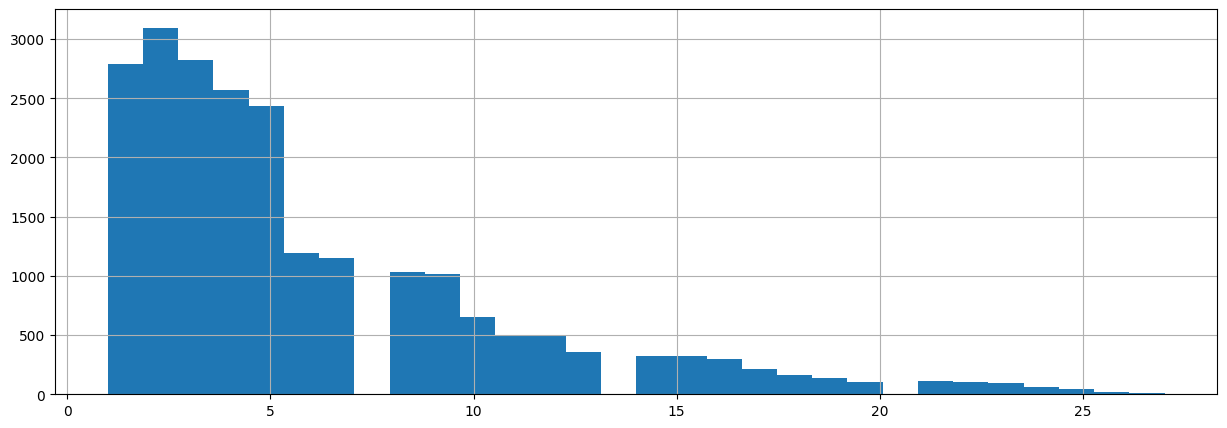

In [57]:
data['floor'].hist(bins=30,figsize=(15, 5))

До 5 этажа находится больше всего квартир.

<Axes: >

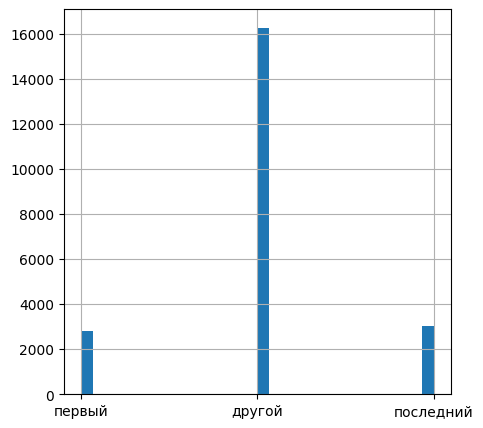

In [58]:
data['category_floor'].hist(bins=30,figsize=(5, 5))

Первый и последний представлены на рыке в равной степени.

<Axes: >

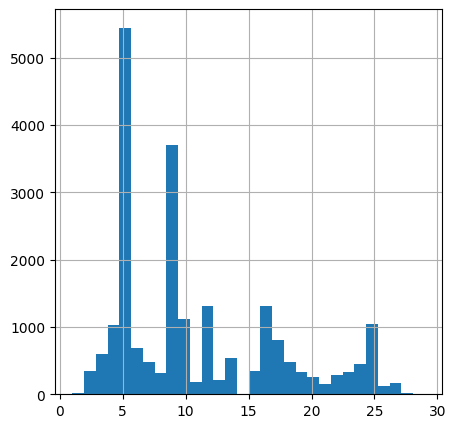

In [59]:
data['floors_total'].hist(bins=30,figsize=(5, 5))

Пики обусловлены стандартом высоты зданий. Больше всего 5к.

<Axes: >

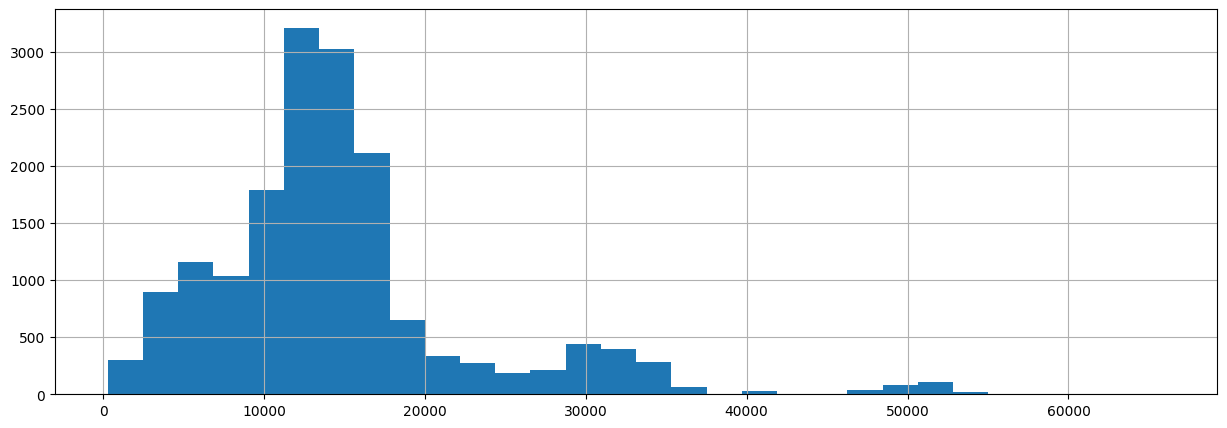

In [60]:
data['city_centers_nearest'].hist(bins=30,figsize=(15, 5))

Подъем и первый пик это город. Дальше это крупные населенные пункты в области.

<Axes: >

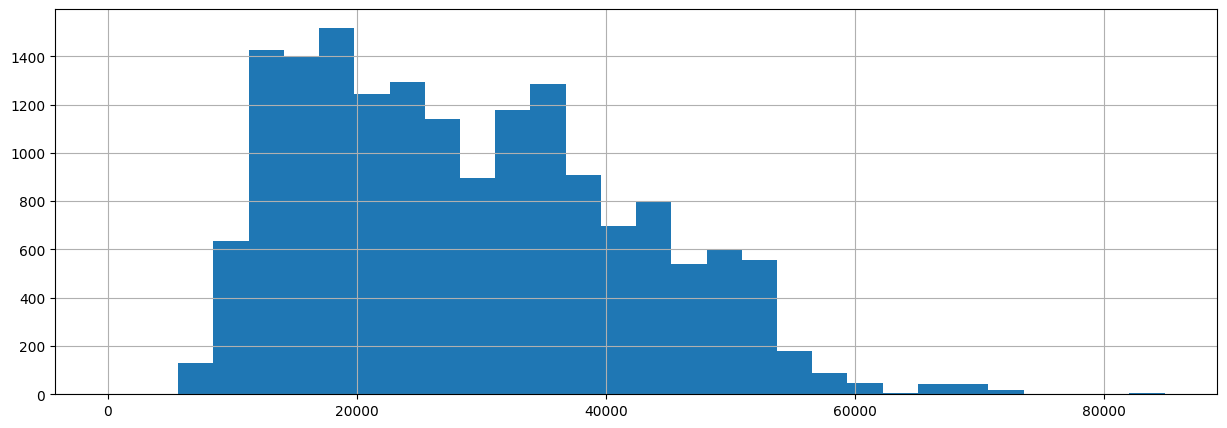

In [61]:
data['airports_nearest'].hist(bins=30,figsize=(15, 5))

Подъем и первый пик это город. Дальше это крупные населенные пункты в области.

<Axes: >

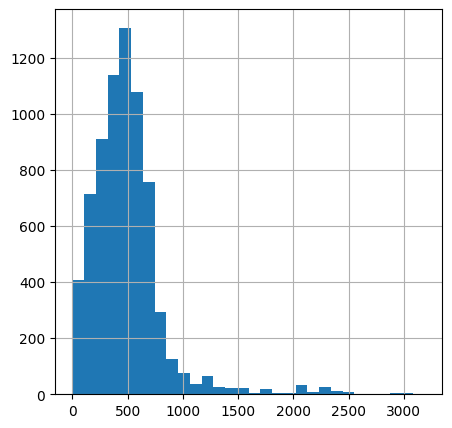

In [62]:
data['parks_nearest'].hist(bins=30,figsize=(5, 5))

У большинства в районе 500м есть парк.

<Axes: >

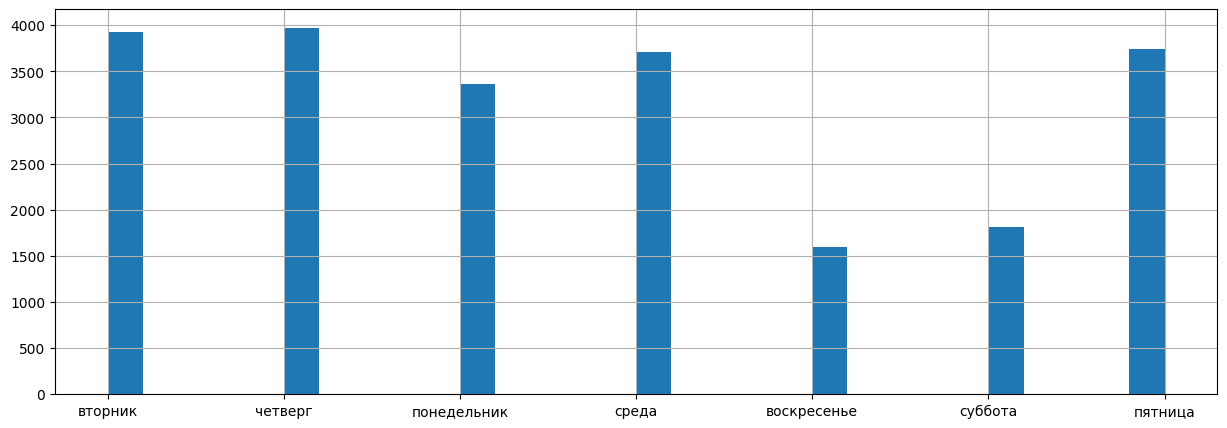

In [63]:
data['day'].hist(bins=30,figsize=(15, 5))

По выходным реже публикуют объявления. 

<Axes: >

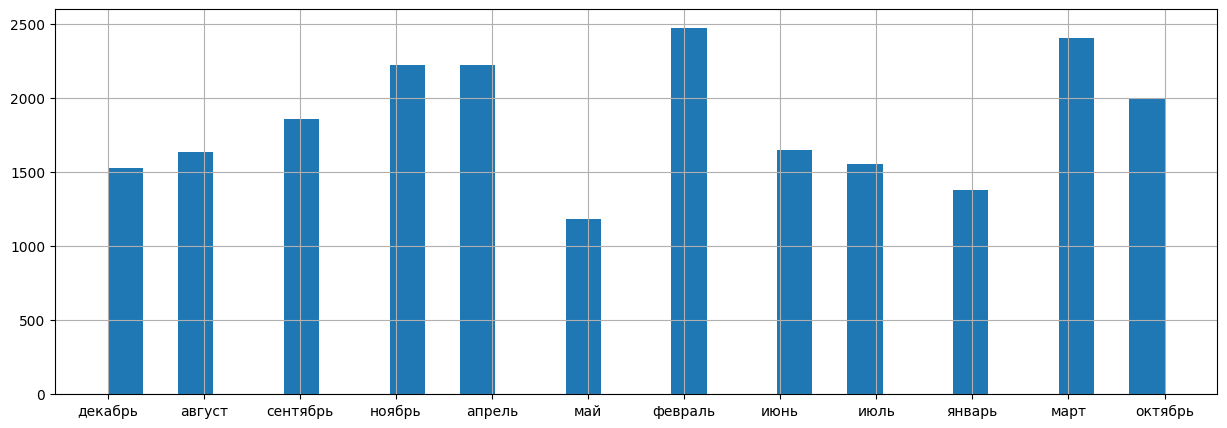

In [64]:
data['month'].hist(bins=30,figsize=(15, 5))

Реже публикуют объявления зимой и в конце весны. Пик в феврале.

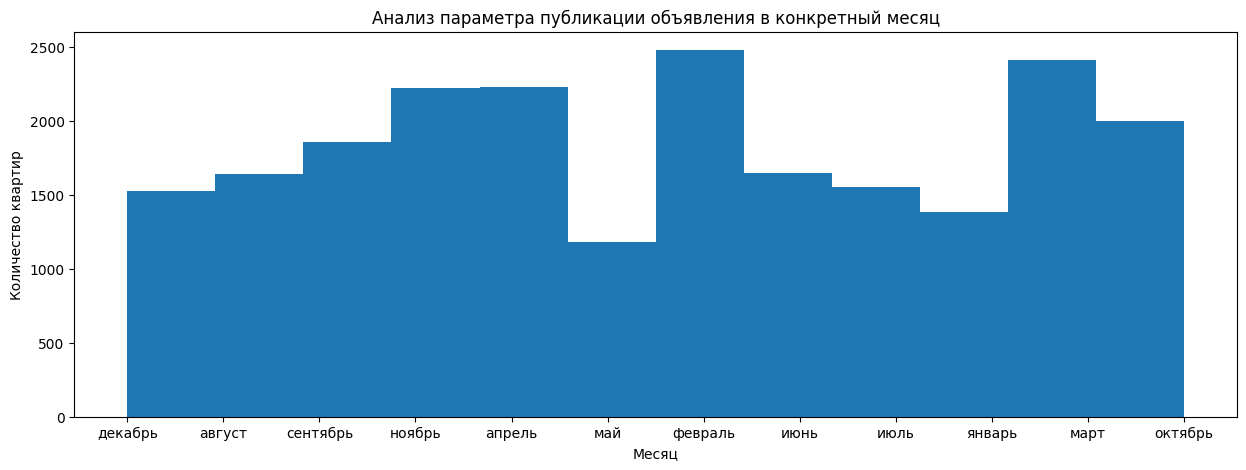

In [65]:
plt.figure(figsize=(15, 5))
plt.hist(data['month'], bins=12, range=(0,11))
plt.title('Анализ параметра публикации объявления в конкретный месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество квартир')
plt.show()

### Изученеи, как быстро продавались квартиры (столбец days_exposition).

In [66]:
data['days_exposition'].describe()

count    19308.000000
mean       175.720012
std        214.271407
min          1.000000
25%         44.000000
50%         93.000000
75%        223.000000
max       1580.000000
Name: days_exposition, dtype: float64

<Axes: >

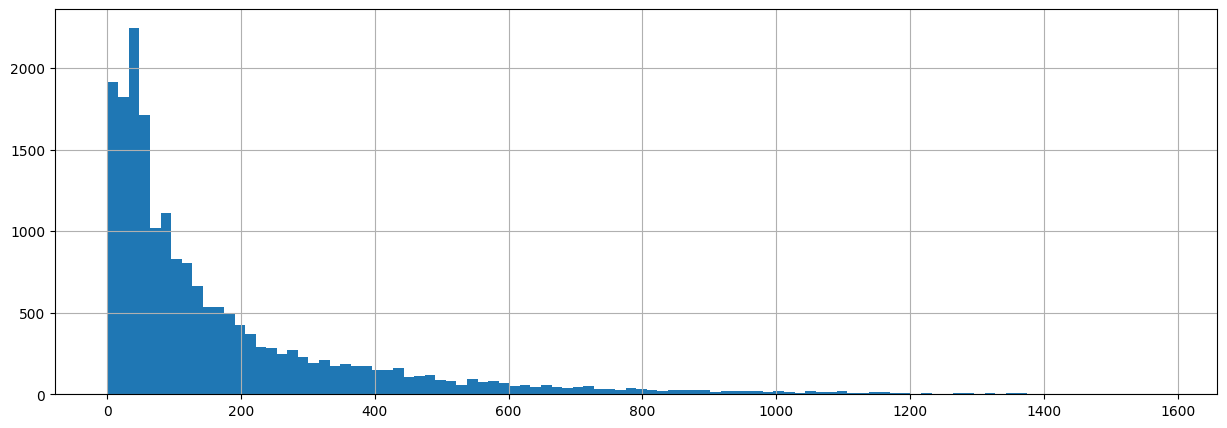

In [67]:
data['days_exposition'].hist( bins=100,figsize=(15, 5))

<Axes: >

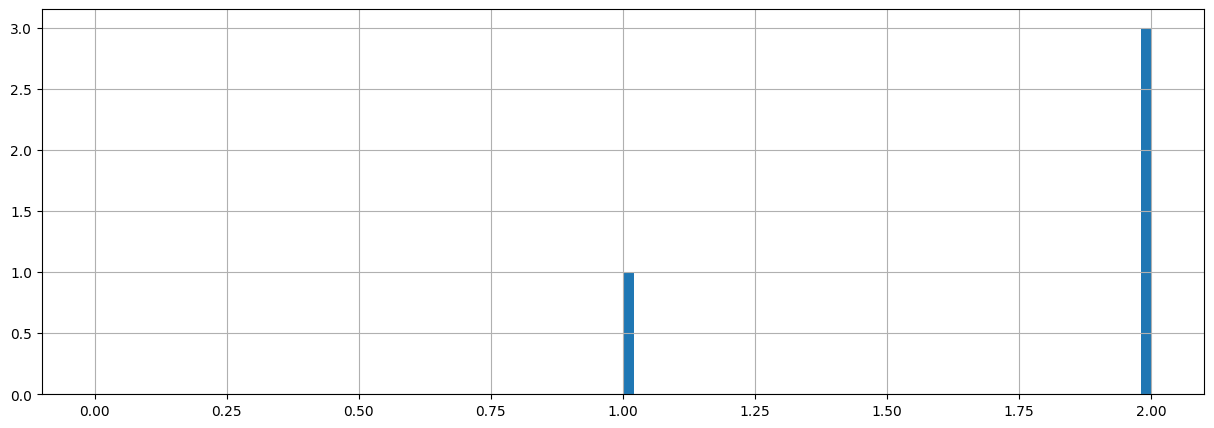

In [68]:
data['days_exposition'].hist(range=(0,2), bins=100,figsize=(15, 5))

<Axes: >

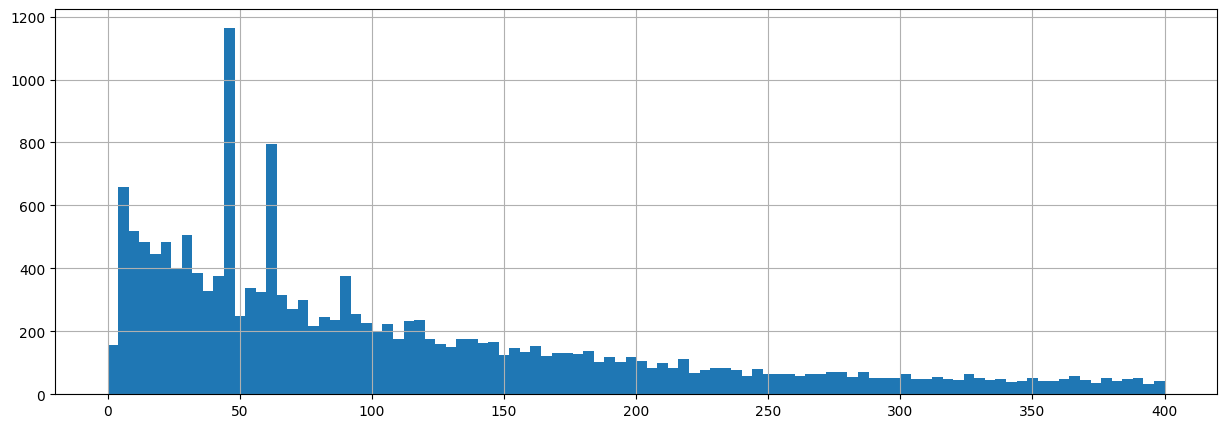

In [69]:
data['days_exposition'].hist(range=(0,400), bins=100,figsize=(15, 5))

<Axes: >

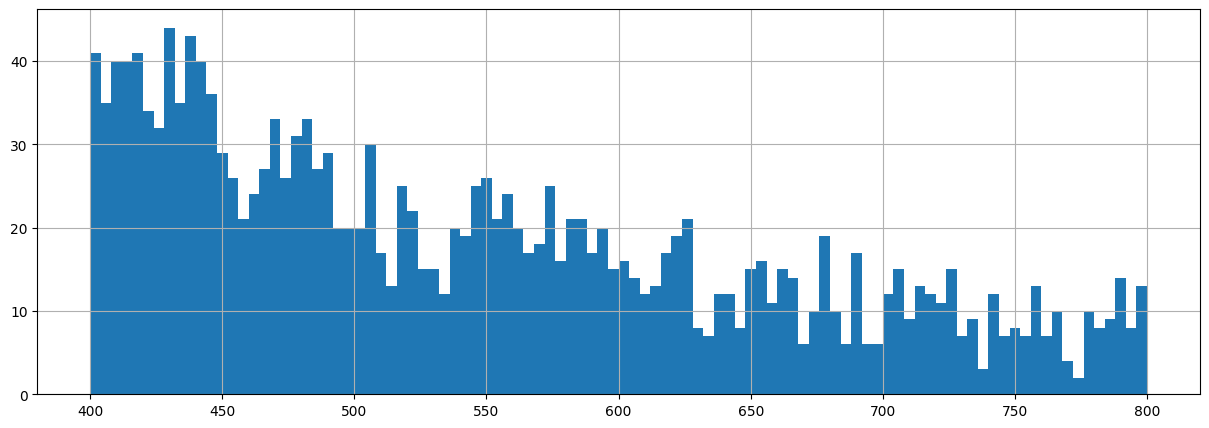

In [70]:
data['days_exposition'].hist(range=(400,800), bins=100,figsize=(15, 5))

<Axes: >

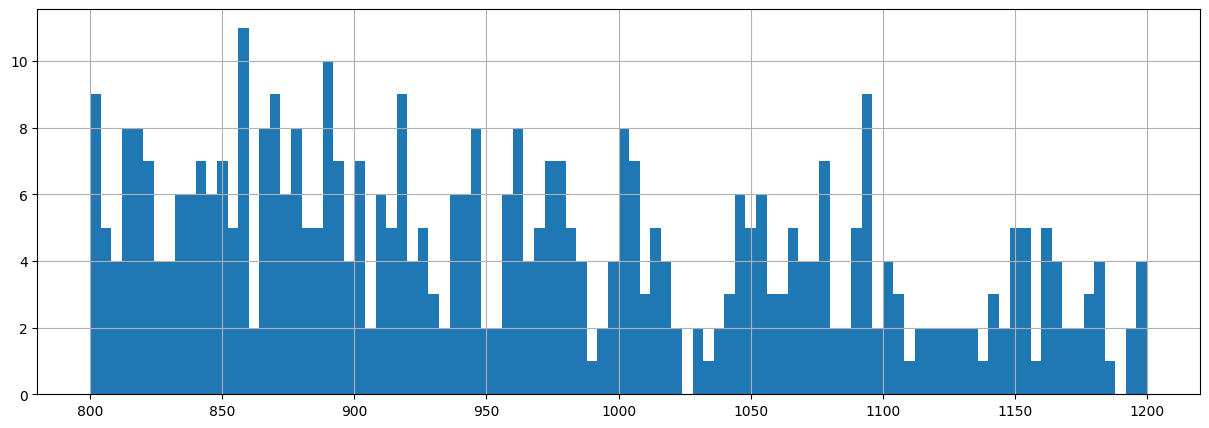

In [71]:
data['days_exposition'].hist(range=(800,1200), bins=100,figsize=(15, 5))

<Axes: >

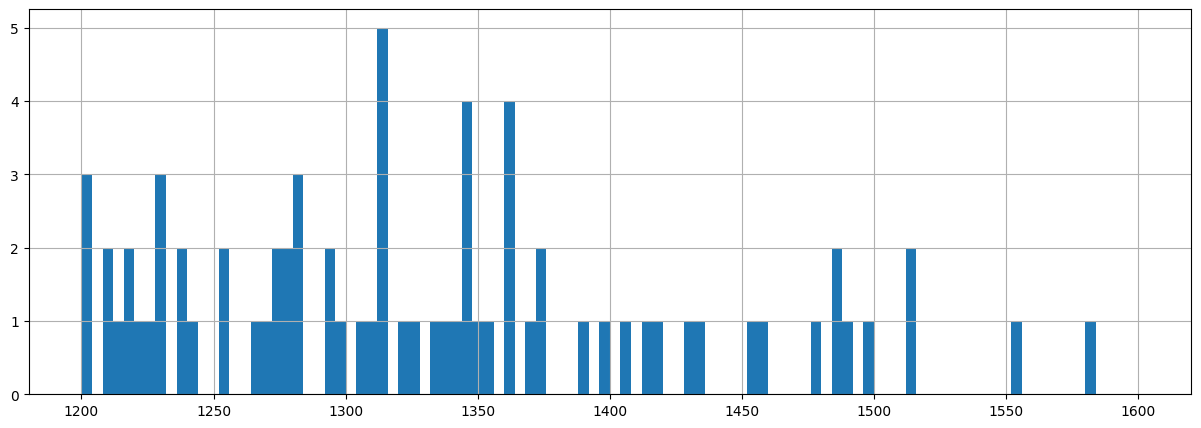

In [72]:
data['days_exposition'].hist(range=(1200,1600), bins=100,figsize=(15, 5))

Основной пик продаж приходится на второй месяц. Редкими по скорости продажи являются квартиры реализованные в первые 2 дня. Основная масса продается в течение 223 дней. Дальше дет плавный спуск до 600 дней и вытягивается в хвост длиной более 4 лет.

### Изучение, зависит ли цена от:

Корреляция 0.7542152999998296


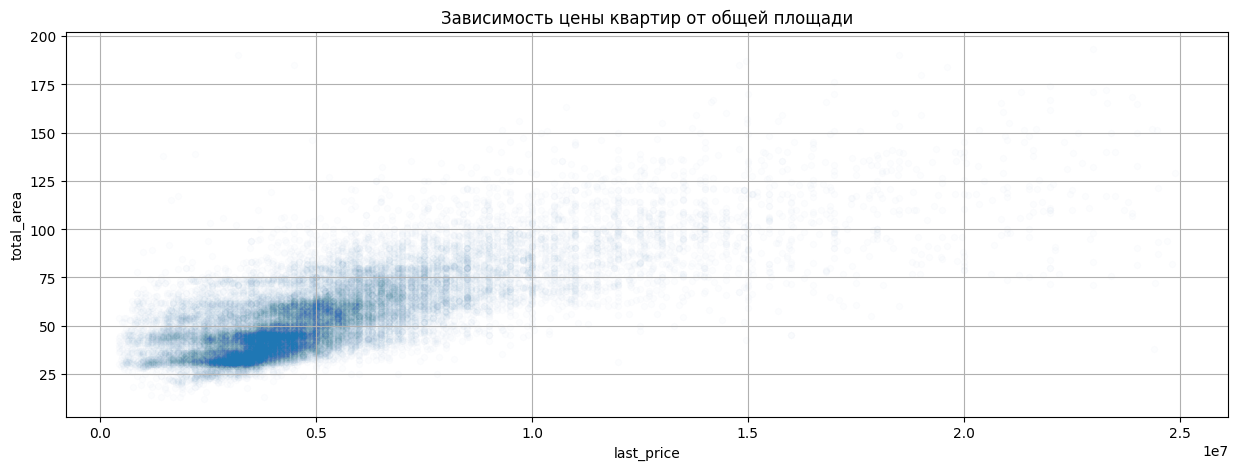

In [73]:
(data
.plot(title='Зависимость цены квартир от общей площади',
x='last_price',
y='total_area',
kind='scatter',
alpha=0.01,
figsize=(15, 5),
grid=True)
)
print('Корреляция', data['total_area'].corr(data['last_price']))

Корреляция 0.650738480378627


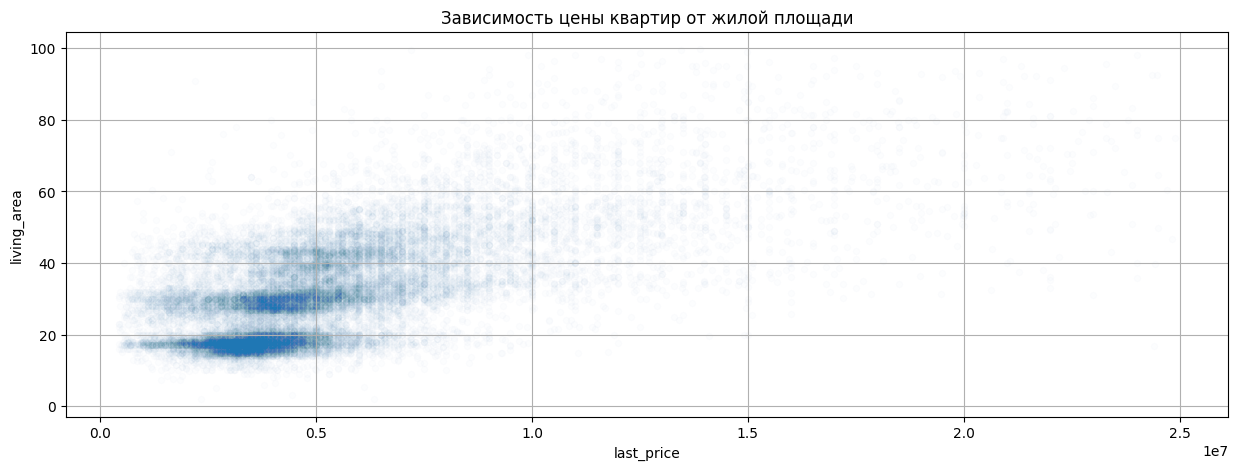

In [74]:
(data
.plot(title='Зависимость цены квартир от жилой площади',
x='last_price',
y='living_area',
kind='scatter',
alpha=0.01,
figsize=(15, 5),
grid=True)
)
print('Корреляция', data['living_area'].corr(data['last_price']))

Корреляция 0.5718252870829786


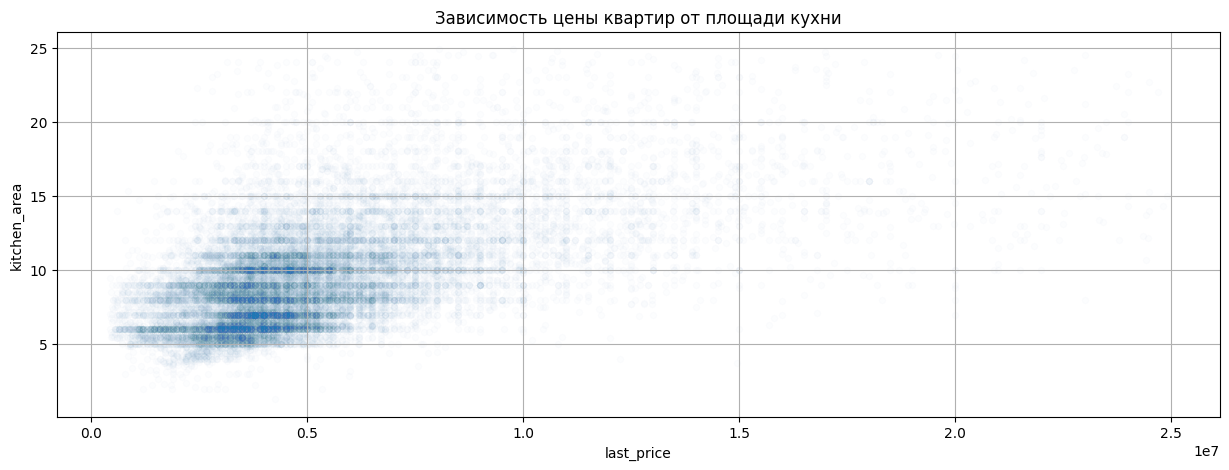

In [75]:
(data
.plot(title='Зависимость цены квартир от площади кухни',
x='last_price',
y='kitchen_area',
kind='scatter',
alpha=0.01,
figsize=(15, 5),
grid=True)
)
print('Корреляция', data['kitchen_area'].corr(data['last_price']))

Увеличение площади любого из данных параметров увеличивает цену, но больше всех влияет общая площадь.

Корреляция 0.46341380661315845


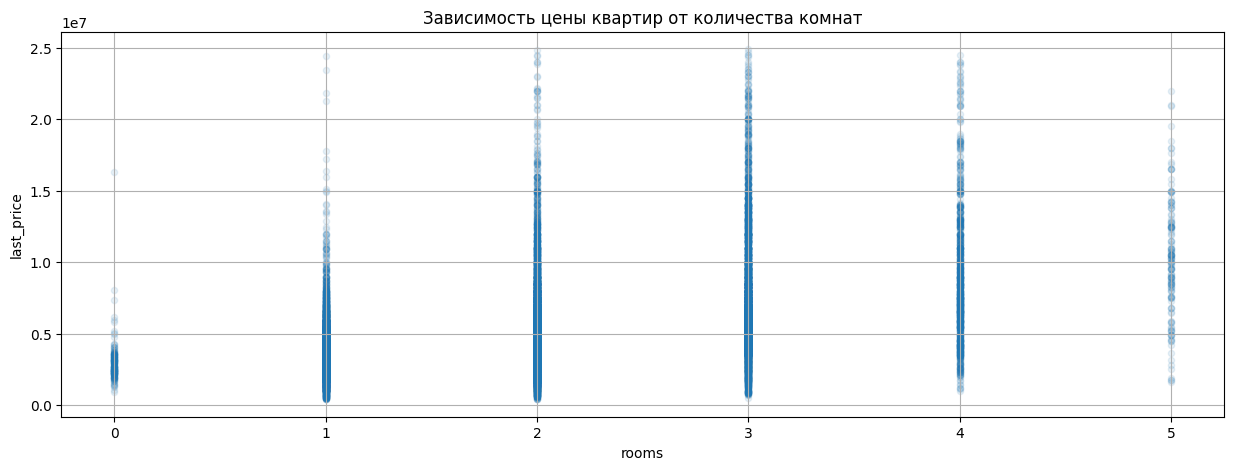

In [76]:
(data
.plot(title='Зависимость цены квартир от количества комнат',
x='rooms',
y='last_price',
kind='scatter',
alpha=0.1,     
figsize=(15, 5),
grid=True)
)
print('Корреляция', data['rooms'].corr(data['last_price']))

От увеличения количества комнат растет цена.

Корреляция 0.46341380661315845


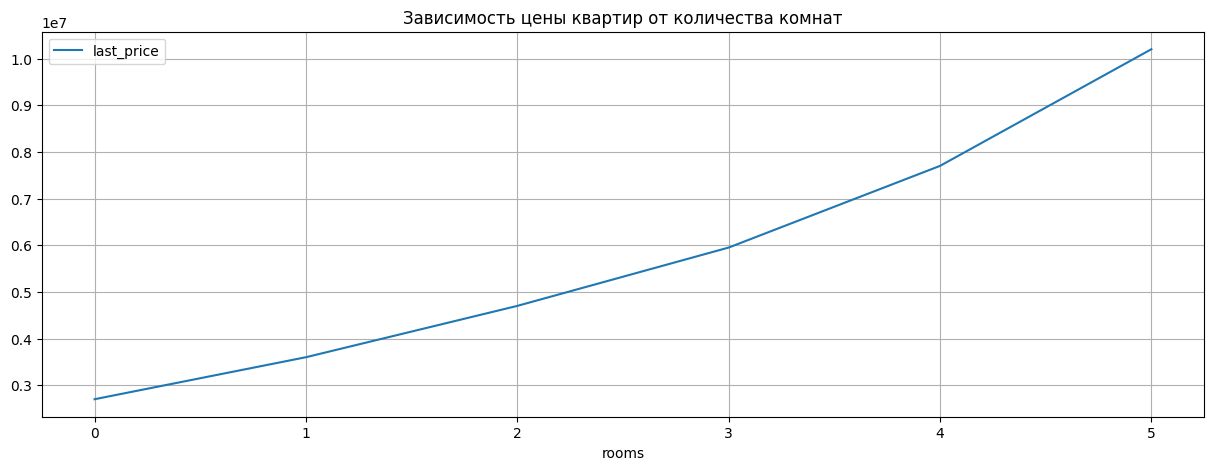

In [77]:
(data
.pivot_table(index='rooms', values='last_price', aggfunc='median')
.plot(title='Зависимость цены квартир от количества комнат', grid=True, figsize=(15,5))
);
print('Корреляция', data['rooms'].corr(data['last_price']))

Корреляция 0.10832169348852186


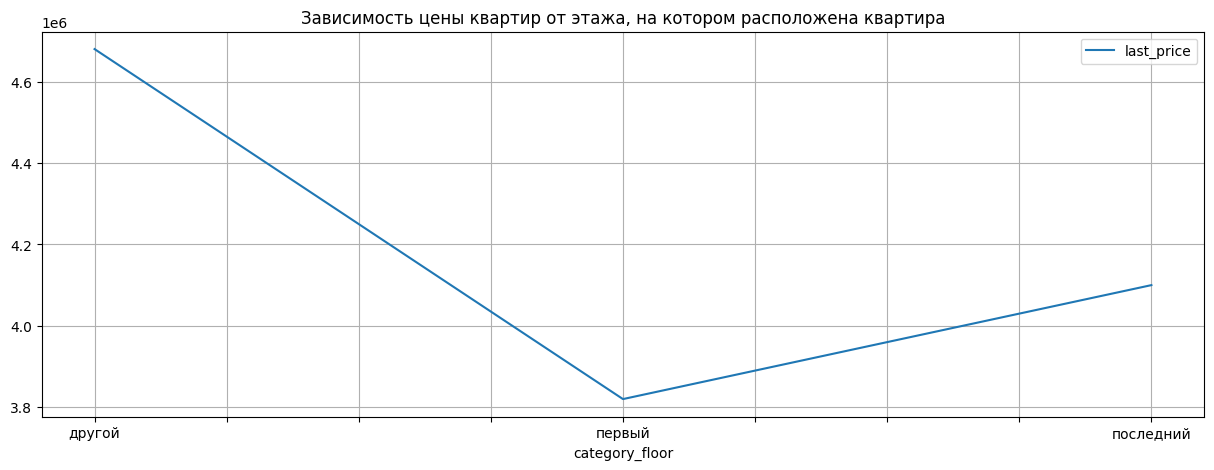

In [78]:
(data
.pivot_table(index='category_floor', values='last_price', aggfunc='median')
.plot(title='Зависимость цены квартир от этажа, на котором расположена квартира', grid=True, figsize=(15,5))
)
print('Корреляция', data['last_price'].corr(data['floor']))

Исходя из графика, квартиры на первом этаже дешевле всего. На последнем - девшевле квартир, находящихся не на крайних этажах. И это очень ожидаемый результат, мы и так знаем, что кайние этажи (первый и последний) - покупатели не особо любят.

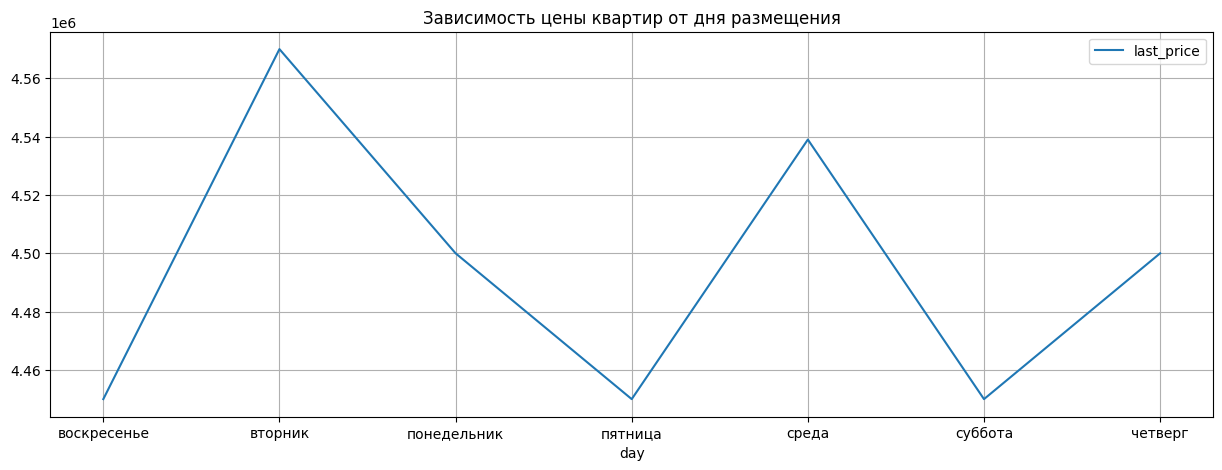

In [79]:
(data
.pivot_table(index='day', values='last_price', aggfunc='median')
.plot(title='Зависимость цены квартир от дня размещения', grid=True, figsize=(15,5))
);

Пик приходится на начало недели потом спад до конца воскресенья.

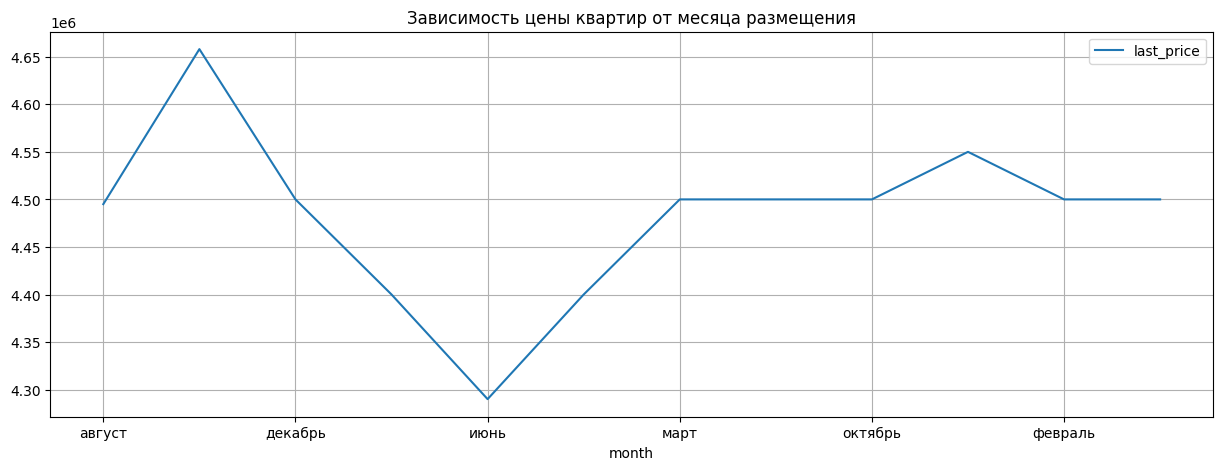

In [80]:
(data
.pivot_table(index='month', values='last_price', aggfunc='median')
.plot(title='Зависимость цены квартир от месяца размещения', grid=True, figsize=(15,5))
);

Понижение цены происходит в июне.

<Axes: title={'center': 'Зависимость цены квартир от года размещения'}, xlabel='year'>

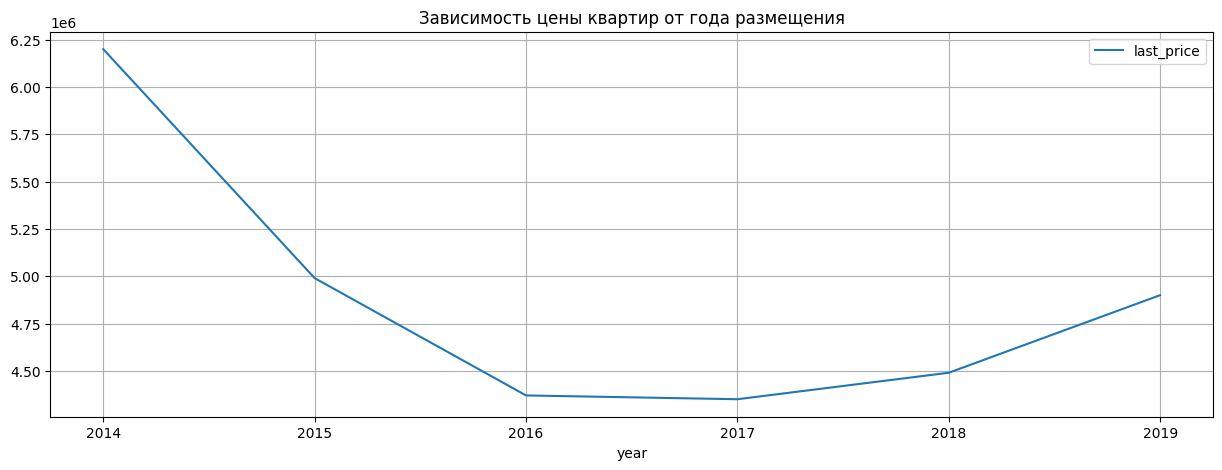

In [81]:
(data
.pivot_table(index='year', values='last_price', aggfunc='median')
.plot(title='Зависимость цены квартир от года размещения', grid=True, figsize=(15,5))
)

Цена на квартиры падала с 2014 по 2016 потом начала постепенно расти.

### Топ - 10

In [82]:
data['locality_name'].value_counts().head(10)

locality_name
Санкт-Петербург    14346
Мурино               583
Кудрово              462
Шушары               436
Всеволожск           387
Пушкин               342
Колпино              336
Парголово            326
Гатчина              302
Выборг               220
Name: count, dtype: int64

In [83]:
top_10 = (data
.pivot_table(index='locality_name',
values='price_per_square',
aggfunc=('count', 'median'))
.sort_values(by='count', ascending=False)
.head(10)  
)

In [84]:
top_10.columns = ['count', 'price_per_square']
top_10

,count,price_per_square
locality_name,,
Санкт-Петербург,14346,103417.5
Мурино,583,86119.0
Кудрово,462,95675.5
Шушары,436,76876.0
Всеволожск,387,65686.0
Пушкин,342,99345.0
Колпино,336,74723.5
Парголово,326,91780.5
Гатчина,302,67746.5


В СПб самая большая стоимость за кв.м. На последнем место по стоимости за 1кв.м находится Выборг.

### Зависимость стоимости объекта от расстояния до центра города.

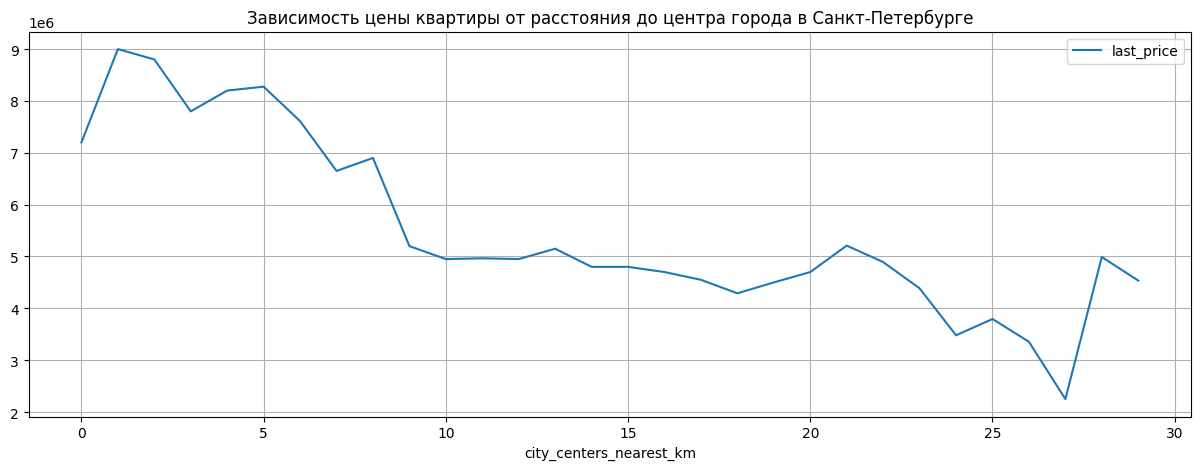

In [85]:
(data
.query('locality_name == "Санкт-Петербург"')
.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='median')
.plot(title='Зависимость цены квартиры от расстояния до центра города в Санкт-Петербурге', grid=True, figsize=(15,5))
);

В самом центре цена чуть ниже чем на небольшом одоление, а в целом удаленность от центра снижает стоимость. Пик в конце это могут быть элитные районы и частные дома.

## Общий вывод

На конечную стоимость квартиры в большей степени влияет её общая площадь и удаленность от центра города. Также может повлиять на цены в целом обстановка на рынке в определенный год.